# Real-time $R_t$ computation on all regions 1

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [2]:
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../data'
BASE_IMAGES_PATH='../../images'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
date_ = os.environ.get("REF_DATE")
if date_ is None:
    date_ = "2021-04-23"
print(date_)

2021-06-13


# ISS Data

## Rt average 14 days

In [4]:
ISS_regions_Rt_avg14 = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_regions_avg14_from_ISS.csv'),
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [5]:
ISS_regions_Rt_avg14.columns

Index(['Region', 'Rt_avg_14days', 'Rt_range_14days_lower',
       'Rt_range_14days_upper', 'computation_time_range_start',
       'computation_time_range_end'],
      dtype='object')

In [6]:
ISS_regions_Rt_avg14['Rt_95_err_max'] = ISS_regions_Rt_avg14.Rt_range_14days_upper - ISS_regions_Rt_avg14.Rt_avg_14days
ISS_regions_Rt_avg14['Rt_95_err_min'] = ISS_regions_Rt_avg14.Rt_avg_14days - ISS_regions_Rt_avg14.Rt_range_14days_lower

In [7]:
ISS_regions_Rt_avg14.tail()

,Region,Rt_avg_14days,Rt_range_14days_lower,Rt_range_14days_upper,computation_time_range_start,computation_time_range_end,Rt_95_err_max,Rt_95_err_min
1150,Toscana,0.69,0.61,0.75,2021-05-19,2021-06-01,0.06,0.08
1151,Trento,0.84,0.62,1.06,2021-05-19,2021-06-01,0.22,0.22
1152,Umbria,0.76,0.58,1.03,2021-05-19,2021-06-01,0.27,0.18
1153,Valle d'Aosta,0.80,0.54,1.11,2021-05-19,2021-06-01,0.31,0.26
1154,Veneto,0.65,0.54,0.78,2021-05-19,2021-06-01,0.13,0.11


In [8]:
ISS_regions_Rt_avg14['Rt_reference_date'] = (
    (
        ISS_regions_Rt_avg14.computation_time_range_start + 
        (ISS_regions_Rt_avg14.computation_time_range_end - ISS_regions_Rt_avg14.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, minutes=-1)
)
ISS_regions_Rt_avg14.sort_values(by='Rt_reference_date', inplace=True)
ISS_regions_Rt_avg14.reset_index(inplace=True, drop=True)

In [9]:
ISS_regions_Rt_avg14[ISS_regions_Rt_avg14.Region=='Piemonte'].tail()

,Region,Rt_avg_14days,Rt_range_14days_lower,Rt_range_14days_upper,computation_time_range_start,computation_time_range_end,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
1058,Piemonte,0.88,0.70,0.98,2021-04-21,2021-05-04,0.10,0.18,2021-04-27 23:59:00
1071,Piemonte,0.81,0.66,0.99,2021-04-28,2021-05-11,0.18,0.15,2021-05-04 23:59:00
1092,Piemonte,0.73,0.57,0.87,2021-05-05,2021-05-18,0.14,0.16,2021-05-11 23:59:00
1113,Piemonte,0.65,0.54,0.78,2021-05-11,2021-05-24,0.13,0.11,2021-05-17 23:59:00
1134,Piemonte,0.66,0.54,0.78,2021-05-19,2021-06-01,0.12,0.12,2021-05-25 23:59:00


## Rt "puntuale"
Which is an average over 7 days

In [10]:
ISS_regions_Rt_punctual = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_regions_punctual_from_ISS.csv'),
    parse_dates=['Date_reference']
)

In [11]:
ISS_regions_Rt_punctual

,Region,Rt_avg_7days,Date_reference
0,Abruzzo,1.13,2020-10-14
1,Basilicata,0.83,2020-10-14
2,Bolzano,1.92,2020-10-14
3,Calabria,1.84,2020-10-14
4,Campania,1.29,2020-10-14
...,...,...,...
499,Toscana,1.02,2021-03-24
500,Trento,0.86,2021-03-24
501,Umbria,0.97,2021-03-24
502,Valle d'Aosta,1.39,2021-03-24


# DPC Data

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [12]:
# tosctemp = pd.read_pickle(os.path.join(BASE_DATA_PATH,'computed/italy/2021-03-26_futbound_08_12_Toscana_MCMC_Rt_pastdays_001_000.pickle'))
# tosctemp.drop(columns=['nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_001','nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_001','nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_001'], inplace=True)
# tosctemp.to_pickle(os.path.join(BASE_DATA_PATH,'computed/italy/2021-03-26_futbound_08_12_Toscana_MCMC_Rt_pastdays_000_000.pickle'))

In [13]:
regions = ['Piemonte', 'Campania', 'Toscana', 'Lombardia']

In [14]:
def merge_regions_data():
    regional_calc_data = None
    for region in regions:
        tempdf = pd.read_pickle(
            os.path.join(BASE_DATA_PATH,
                         f'computed/italy/{date_}_futbound_08_12_{region}_MCMC_Rt_pastdays_000_000.pickle'))
        cols = tempdf.columns.tolist()
        tempdf['Region'] = region
        tempdf = tempdf[['Region']+cols]
        if regional_calc_data is None:
            regional_calc_data = tempdf
        else:
            regional_calc_data = pd.concat((regional_calc_data, tempdf))

    regional_calc_data.sort_values(by=['data', 'Region'], inplace=True)
    regional_calc_data.drop(columns='index', inplace=True)
    regional_calc_data.reset_index(drop=True, inplace=True)
    
    regional_calc_data.to_pickle(
        os.path.join(
            BASE_DATA_PATH, 
            f'computed/italy/{date_}_TD_calc_Regions_MCMC_Rt.pickle')
    )

In [15]:
# uncomment to merge regions data into a single pickle, subsequently loaded
# then re-comment before committing the notebook

merge_regions_data()

In [16]:
regional_calc_data = pd.read_pickle(os.path.join(BASE_DATA_PATH,
    f'computed/italy/{date_}_TD_calc_Regions_MCMC_Rt.pickle'))

In [17]:
regional_calc_data[regional_calc_data.Region=='Piemonte'].tail()

,Region,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,...,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000
1886,Piemonte,2021-06-09 23:59:00,ITA,1,Piemonte,45.073274,7.680687,386,53,439,...,NaN,343100.0,18634.0,2960007.0,1705951.0,ITC,ITC1,0.789264,0.625155,0.963586
1890,Piemonte,2021-06-10 23:59:00,ITA,1,Piemonte,45.073274,7.680687,367,49,416,...,NaN,343229.0,18642.0,2966236.0,1715681.0,ITC,ITC1,0.645124,0.499608,0.797325
1894,Piemonte,2021-06-11 23:59:00,ITA,1,Piemonte,45.073274,7.680687,351,47,398,...,NaN,343341.0,18656.0,2972382.0,1732153.0,ITC,ITC1,0.452535,0.334156,0.575636
1898,Piemonte,2021-06-12 23:59:00,ITA,1,Piemonte,45.073274,7.680687,325,45,370,...,NaN,343425.0,18662.0,2977586.0,1749221.0,ITC,ITC1,0.265414,0.180099,0.357449
1902,Piemonte,2021-06-13 23:59:00,ITA,1,Piemonte,45.073274,7.680687,317,47,364,...,NaN,343480.0,18666.0,2980702.0,1754205.0,ITC,ITC1,0.125067,0.066854,0.186526


In [18]:
def plot_simulation_results(
    region, simdf, ISSdf, ISSdfpunctual, xmin=datetime(2020,7,25), ylim=(0.2,2), 
    
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'italy/TD_Rt_{}_computation_MCMC_150dpi')):
    img_file_path_without_extension = img_file_path_without_extension.format(region)
    
    region_df = simdf[simdf.Region==region]
    ISS_region_df = ISSdf[ISSdf.Region==region]
    ISS_region_punctual_df = ISSdfpunctual[ISSdfpunctual.Region==region]
    plotting.plot_series(
        title=f'Rt giornaliero {region}',
        message='Aggiornamento del {}'.format(region_df.data.max().strftime('%d %b %Y')),
        data=[
            {
                'df': ISS_region_df,
                'xfield': 'Rt_reference_date',
                'yfields': ['Rt_avg_14days'],
                'bars': [['Rt_95_err_min','Rt_95_err_max']],
                'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
                'labels': [f'Stima di $R_t$ medio 14gg {region} pubblicata dall\'Istituto Superiore di Sanità, \ncon range di possibile variazione nel periodo'],
                'colors': ['blue']
            },
            #{
            #    'df': ISS_region_punctual_df,
            #    'xfield': 'Date_reference',
            #    'yfields': ['Rt_avg_7days'],
            #    'labels': [f'Stima di $R_t$ puntuale {region} pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            #    'colors': ['green']
            #},
            {
                'df': region_df,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000', 
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000',
                ],
                'labels': [
                    f'Stima di $R_t$ {region} sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
                ],
                'colors':['orange']
            },
        ],
        legend_fontsize=27,
        xlim=(xmin, region_df.data.max()),
        ylim=ylim,
        legend_loc='lower right',
        img_file_path_without_extension=img_file_path_without_extension,
        dpi=150,
        quality=60
    )

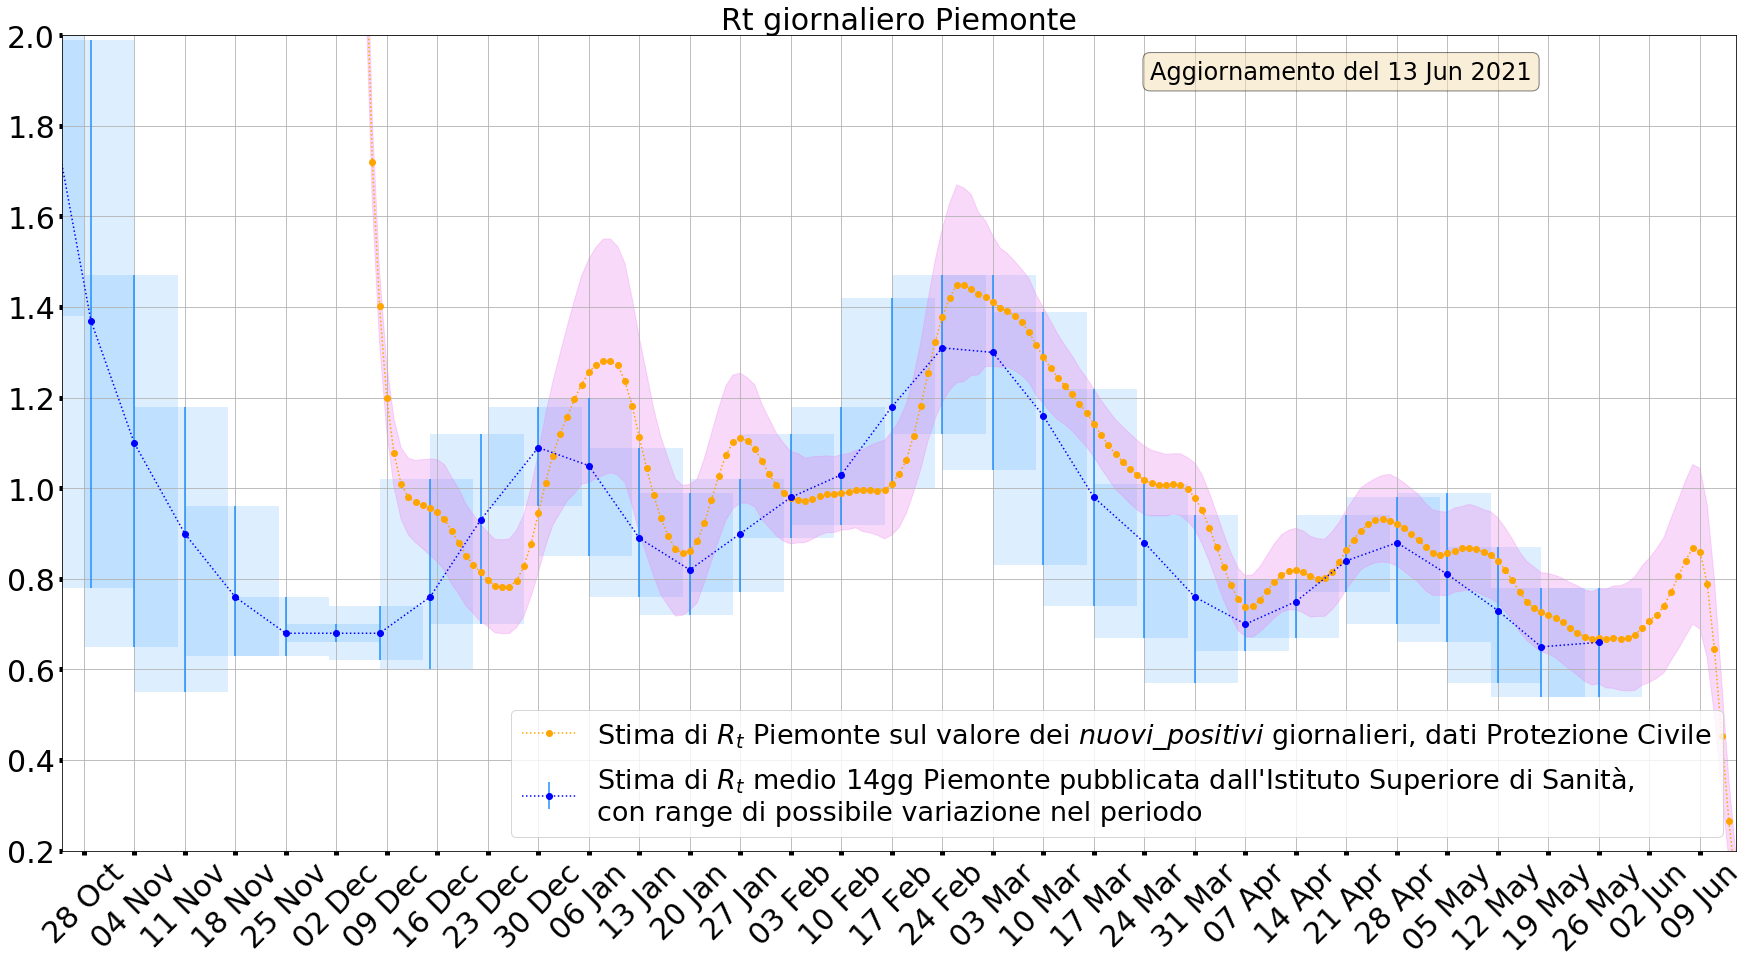

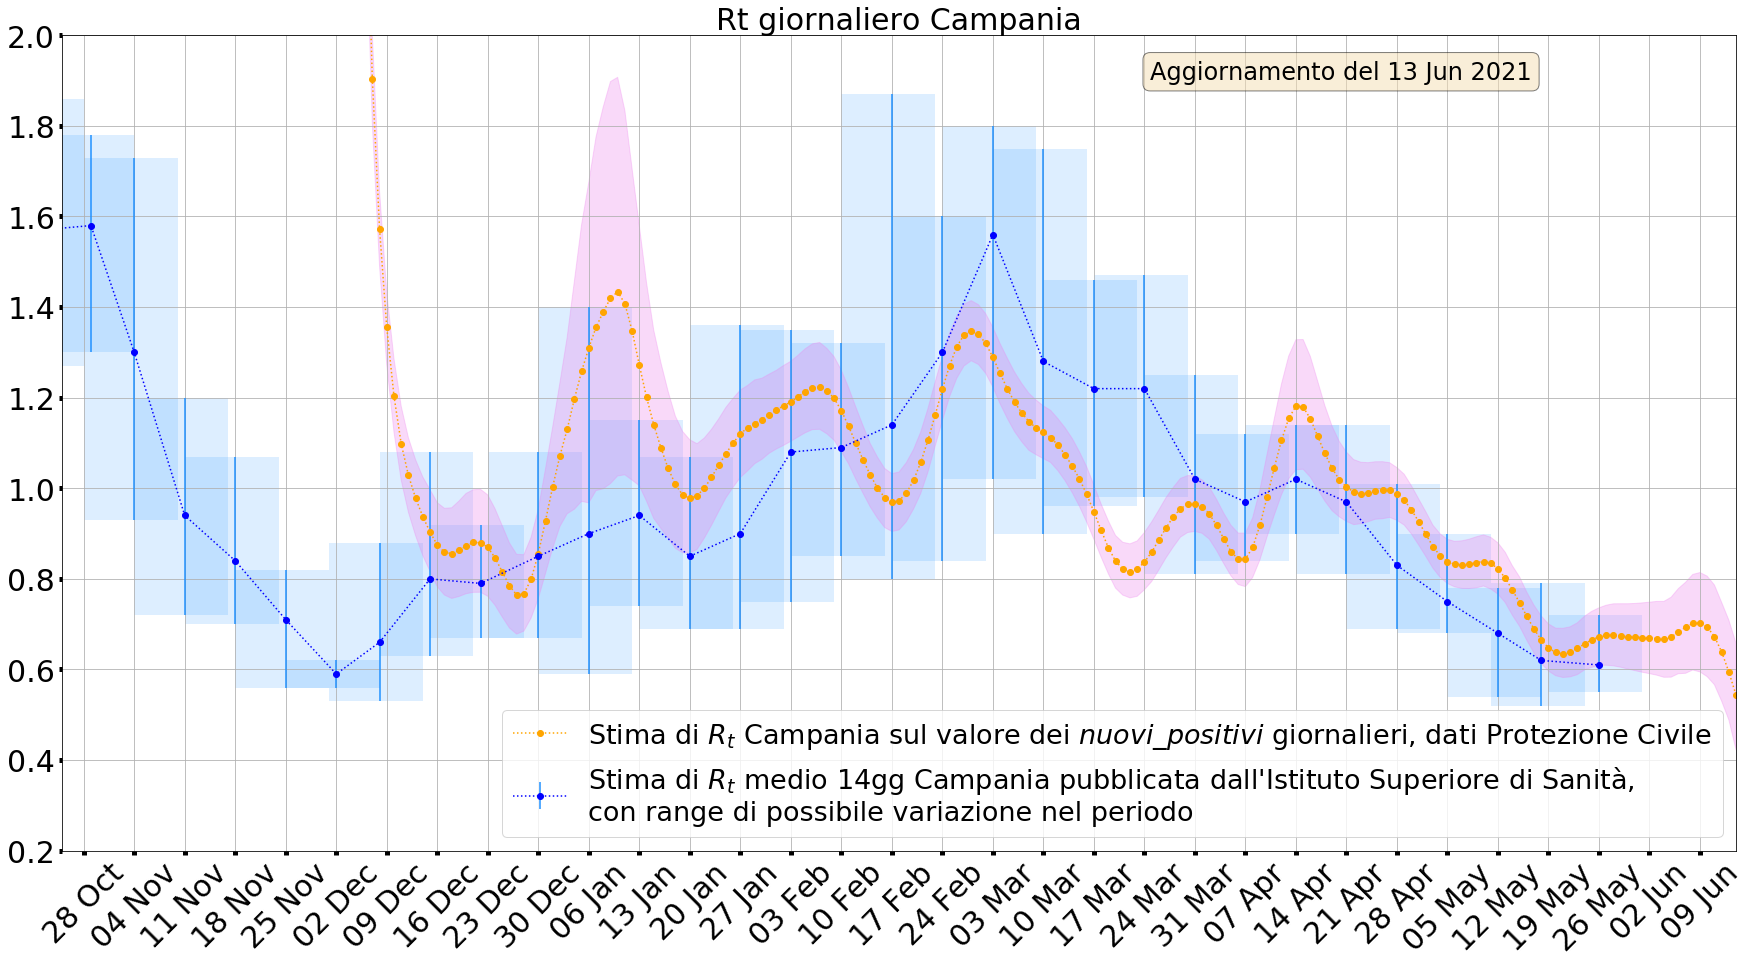

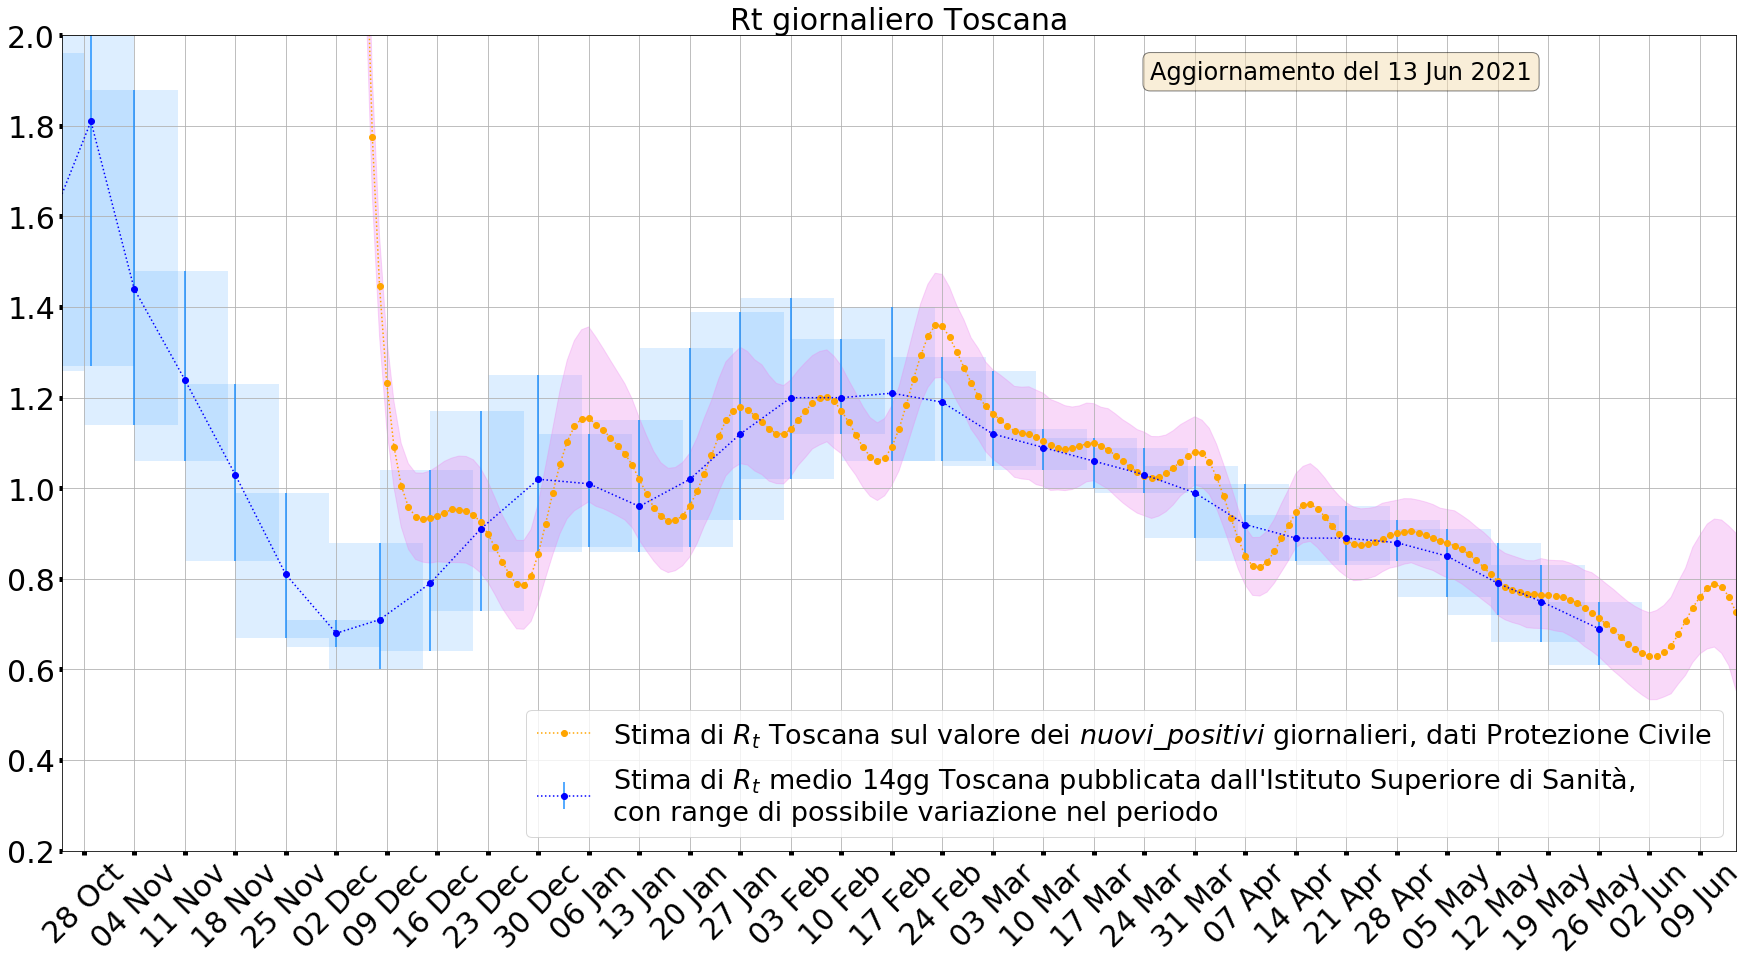

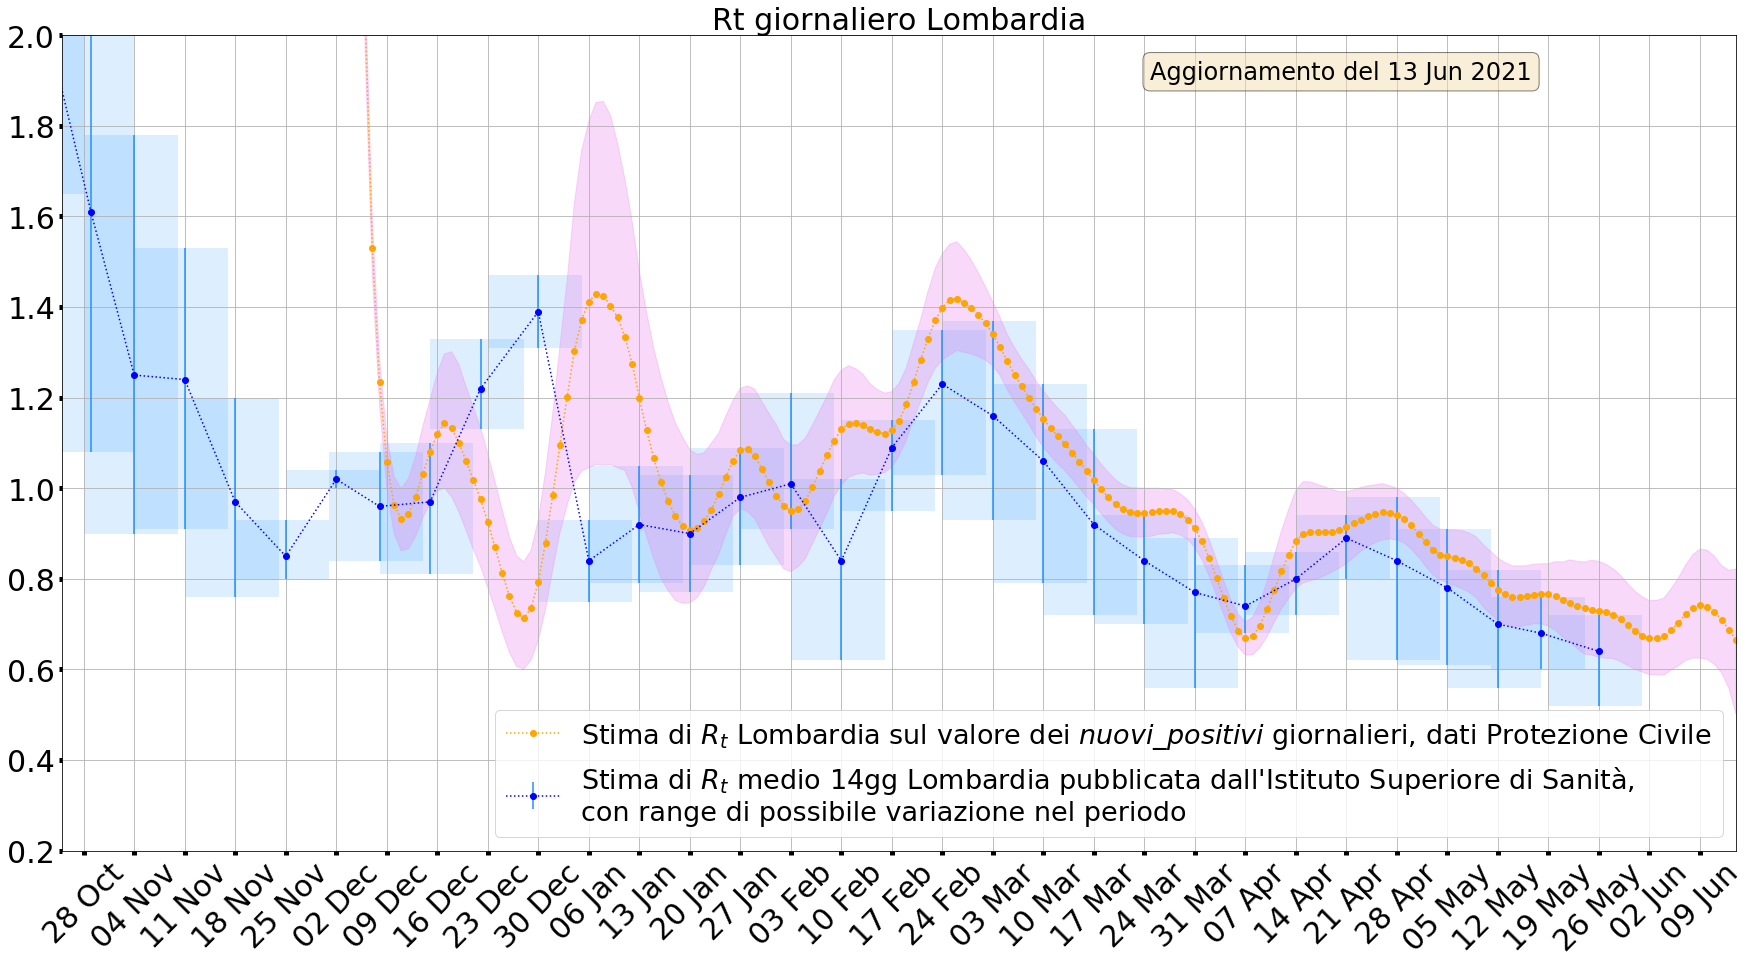

In [19]:
for region in regions:
    plot_simulation_results(
        region, regional_calc_data, ISS_regions_Rt_avg14, ISS_regions_Rt_punctual, xmin=datetime(2020,10,25))

In [20]:
regional_calc_data.loc[regional_calc_data.Region.isin(regions),
                  ['data', 'Region','nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000',
                   'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000',
                   'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000']].tail()

,data,Region,nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000,nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000
1899,2021-06-12 23:59:00,Toscana,0.760782,0.608635,0.916805
1900,2021-06-13 23:59:00,Campania,0.543260,0.422448,0.657551
1901,2021-06-13 23:59:00,Lombardia,0.665657,0.500779,0.821854
1902,2021-06-13 23:59:00,Piemonte,0.125067,0.066854,0.186526
1903,2021-06-13 23:59:00,Toscana,0.725925,0.553627,0.900769


In [21]:
last_values = regional_calc_data.loc[
    (regional_calc_data.Region.isin(regions))&(regional_calc_data.data==regional_calc_data.data.max()),
      ['data', 'Region','nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000',
       'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000',
       'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000']    
]

In [22]:
for _, r in last_values.iterrows():
    print(f'{r.Region}: {r.nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000:.2f} ({r.nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000:.2f} - {r.nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000:.2f})')

Campania: 0.54 (0.42 - 0.66)
Lombardia: 0.67 (0.50 - 0.82)
Piemonte: 0.13 (0.07 - 0.19)
Toscana: 0.73 (0.55 - 0.90)
